# Evaluator-optimizer: Langgraph 와 Langfuse 로 Amazon Bedrock 시작하기

이 노트북은 [Langfuse](https://langfuse.com/) 를 사용하여 Amazonb Bedrock 의 LLM 을 사용하는 방법을 
가이드하는 노트북 입니다.

구체적으로 LangGraph 로 Evaluator-optimizer 하는 방법을 배웁니다.

### 참조
- [LangGraph: Workflows and Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#prompt-chaining)
- [Local Deep Researcher](https://github.com/langchain-ai/local-deep-researcher)



---

## 1. 선수 사항: 
### 1.1 Langfuse 사용 환경 및 콘다 가상 환경 생성
- 아래의 설치 가이드에 따라 먼저 진행 해주세요.
    - [환경 설치 가이드: ](https://github.com/aws-samples/aws-ai-ml-workshop-kr/tree/master/genai/aws-gen-ai-kr/20_applications/19_agentic_rag)


### 1.2. Key 정보를 저장하는 env 파일 생성
-  ../../.env 파일을 생성하고 아래의 내용을 작성, 19_agentic_rag 폴더 아래에 생성 하시면 됩니다.
    ```
    LANGFUSE_SECRET_KEY=<secret key>
    LANGFUSE_PUBLIC_KEY=<public key>
    LANGFUSE_HOST=<host url>
    ```    

## 2. 환경 설정

In [66]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)


module_path = ".."
add_python_path(module_path)

from utils.langgraph_util import ( 
    show_graph_dag,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse already exists
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse/03_langgraph', '/home/sagemaker-user/.conda/envs/langgraph/lib/python310.zip', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse']


## 3. 환경 변수 로딩
아래와 같은 환경 변수를 로딩 함.
```
LANGSMITH_TRACING=true
LANGSMITH_API_KEY=your_langsmith_api_key
OPENAI_API_KEY=your_openai_api_key
```

In [67]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("../../.env")



True

## 4. langfuse_handler 핸들러 작성하기

In [68]:
from langfuse.callback import CallbackHandler
import os

langfuse_handler = CallbackHandler(
    public_key=os.environ.get('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.environ.get('LANGFUSE_SECRET_KEY'),
    host=os.environ.get('LANGFUSE_HOST'),
)

### langfuse endpoint 에 인증 해보기

In [69]:
# connection test
langfuse_handler.auth_check()

True

## 5. LangChain 인터페이스의 Bedrock 모델 생성
- LangChain 개발자 가이드: [ChatBedrock](https://python.langchain.com/docs/integrations/chat/bedrock/)

]

In [70]:
from langchain_aws import ChatBedrockConverse

model_id = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
# model_id = "us.amazon.nova-pro-v1:0"
# model_id = "us.anthropic.claude-3-5-haiku-20241022-v1:0"

llm = ChatBedrockConverse(
    model= model_id,
    temperature=0,
    max_tokens=None,
    # other params...
)

llm

ChatBedrockConverse(client=<botocore.client.BedrockRuntime object at 0x7f5e91179510>, model_id='us.anthropic.claude-3-7-sonnet-20250219-v1:0', temperature=0.0, region_name='us-east-1', provider='anthropic', supports_tool_choice_values=('auto', 'any', 'tool'))

## 6. Grpah 정의 하기

In [71]:
from pydantic import BaseModel, Field
from typing import Literal
# from typing import Annotated, List
# import operator
# from langchain_core.messages import SystemMessage, HumanMessage


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it in Korean.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

### State 정의

In [72]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

from langgraph.constants import Send

# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

### Node 및 분기  함수 정의

In [73]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} in Korean but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke in Korean about {state['topic']} in Korean")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""
    prompt = f"""
    당신은 농담 평가 전문가입니다. 다음 농담을 엄격하고 객관적인 기준으로 평가해주세요:

    농담: {state['joke']}
    
    평가 기준:
    1. 창의성: 평범하거나 뻔한 농담은 낮은 점수를 줍니다.
    2. 어색함: 언어 사용이 어색하거나 매끄럽지 않은 경우 재미없는 것으로 간주합니다.
    3. 논리: 농담의 논리가 이해하기 어렵거나 비약이 큰 경우 재미없는 것으로 간주합니다.
    4. 신선함: 흔하게 들을 수 있는 농담은 재미없는 것으로 간주합니다.
    
    중요: 단순히 예의상 긍정적인 평가를 하지 마세요. 농담의 퀄리티에 대해 정직하고 엄격하게 평가하세요.
    많은 농담이 실제로는 '재미없음(not funny)' 범주에 속합니다. 농담의 약 70%는 'not funny'로 평가되어야 합니다.
    
    당신의 평가는 향후 더 좋은 농담을 생성하는 데 중요한 역할을 합니다.
    """

    grade = evaluator.invoke(prompt)
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


In [74]:
# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

### 그래프 구조 만들기

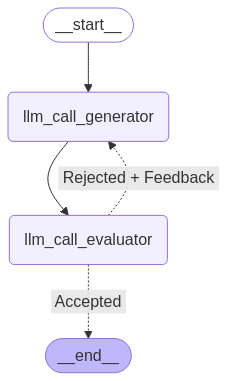

In [75]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

### Graph 호출

In [76]:
# Invoke
state = optimizer_workflow.invoke({"topic": "고양이"},
    config={
            "callbacks": [langfuse_handler],
        }
)

### 최종 State 값 보기
- 각 Node 에서 State Class 의 변수에 값을 할당함.

In [77]:
state

{'joke': '# 고양이 농담\n\n고양이가 카페에 들어가서 주문을 했어요.\n"아메리카노 한 잔 주세요."\n바리스타가 물었어요. "성함이 어떻게 되세요?"\n고양이가 대답했어요. "냥기명으로 해주세요."\n\n바리스타가 커피를 내놓으며 외쳤어요. "냥기명 손님, 아메리카노 나왔습니다!"\n그러자 카페에 있던 모든 고양이들이 일제히 고개를 돌렸답니다.\n\n---\n\n이 농담은 한국어의 \'익명\'(이름을 밝히지 않음)과 \'냥기명\'(고양이 소리 \'냥\'을 활용한 말장난)의 언어유희를 사용했고, 카페에서 이름을 부르는 한국의 문화적 맥락과 고양이들이 자기 이름이 불린 것이 아닌데도 반응하는 특성을 결합했습니다.',
 'topic': '고양이',
 'feedback': '이 농담은 전반적으로 잘 구성되어 있습니다. \'익명\'과 \'냥기명\'의 언어유희가 창의적이고, 한국의 카페 문화와 고양이의 특성을 잘 결합했습니다. 다만 더 강화하기 위해서는:\n\n1. 마지막 부분에서 고양이들이 반응하는 장면을 좀 더 구체적으로 묘사하면 더 웃음을 줄 수 있을 것입니다. 예를 들어 "그러자 카페에 있던 모든 고양이들이 일제히 고개를 돌리며 \'내 이름도 냥기명인데!\' 하고 생각했답니다."\n\n2. 바리스타의 반응을 추가하여 상황의 재미를 더할 수 있습니다. 예를 들어 "바리스타는 갑자기 자신이 고양이 카페에서 일하고 있다는 것을 깨달았습니다."\n\n3. 농담의 도입부에서 왜 고양이가 카페에 들어갔는지에 대한 약간의 배경 설명이 있으면 더 풍부해질 수 있습니다.\n\n하지만 전체적으로 언어유희와 문화적 맥락을 잘 활용한 재미있는 농담입니다.',
 'funny_or_not': 'funny'}

### State 값 흐름에 따라 출력

In [78]:
from IPython.display import Markdown
Markdown(state["joke"])
# print(state["joke"])


# 고양이 농담

고양이가 카페에 들어가서 주문을 했어요.
"아메리카노 한 잔 주세요."
바리스타가 물었어요. "성함이 어떻게 되세요?"
고양이가 대답했어요. "냥기명으로 해주세요."

바리스타가 커피를 내놓으며 외쳤어요. "냥기명 손님, 아메리카노 나왔습니다!"
그러자 카페에 있던 모든 고양이들이 일제히 고개를 돌렸답니다.

---

이 농담은 한국어의 '익명'(이름을 밝히지 않음)과 '냥기명'(고양이 소리 '냥'을 활용한 말장난)의 언어유희를 사용했고, 카페에서 이름을 부르는 한국의 문화적 맥락과 고양이들이 자기 이름이 불린 것이 아닌데도 반응하는 특성을 결합했습니다.

## 7. Langfuse Tracing Output
![generator-evaluator.png](img/generator-evaluator.png)